<a href="https://colab.research.google.com/github/Bennath-coder/Bennath-coder/blob/main/S5_020P_a%CC%80_022P_UseCaseEnonce_version_avec_Keras_vNPz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip
!pip install tensorflow==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 35.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver do

In [2]:
import tensorflow
print(tensorflow.__version__)

2.16.1


In [3]:
import keras
print(keras.__version__)

3.8.0


# Importation des packages et du dataset

En plus des packages habituels, nous importons TensorFlow et Keras pour construire notre réseau de neurones.

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, f1_score

In [5]:
df_path = "https://raw.githubusercontent.com/jslhost/dataset_repo/main/churn_complete.csv"

df = pd.read_csv(df_path)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Ce dataset nous donne des informations relatives aux clients d'une banque. Nous souhaitons évaluer pour chaque client le risque de *churn*, c'est-à-dire leur propension à quitter la banque. Le dataset comporte treize variables dont la variable à prédire :
* **CustomerId** : identifiant unique du client,
* **Surname** : prénom du client,
* **CreditScore** : score exposant la capacité du client à rembourser un prêt,
* **Geography** : pays de résidence du client (France, Spain ou Germany),
* **Gender** : genre du client (Female ou Male)
* **Age** : âge du client en années,
* **Tenure** : nombre d'années d'ancienneté dans la banque,
* **Balance** : solde du compte du client,
* **NumOfProducts** : nombre de produits bancaires auxquels le client a souscrit,
* **HasCrCard** : le client dispose d'une carte de crédit(1) ou non (0),
* **IsActiveMember** : le client est actif (1) ou inactif (0),
* **EstimatedSalary** : estimation du salaire du client,
* **Exited** : le client a quitté la banque (1) ou est resté (0) — **variable à prédire**

*Il s'agit d'un dataset simplifié à partir du dataset suivant : https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn*

# Feature engineering et Exploratory Data Analysis

**Identifier et supprimer les colonnes non exploitables.**

In [6]:
# prompt: df.info()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


**Convertir la variable `Gender` en variable numérique.**

In [8]:
# 1. Supprimer les colonnes avec des valeurs manquantes (NaN) à 100%
new_df = df.drop(columns=['CustomerId', 'Surname'], axis=1) # Supprimer les colonnes inutiles au modèle de prediction

# 2. Supprimer les colonnes constantes (où toutes les valeurs sont identiques)
new_df = new_df.loc[:, new_df.nunique() > 1]  # Supprimer les colonnes avec une seule valeur unique

# 3. Supprimer les NaN
new_df = new_df.dropna()  # Supprimer les lignes avec des valeurs manquantes

# Résultat final après nettoyage
new_df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Intéressons-nous au pays de résidence de chaque client. Cette variable n'est pas numérique mais nous souhaitons tout de même la conserver.

**Créer trois variables binaires `France`, `Spain`et `Germany` à partir de la variable `Geography`.**

*La fonction `get_dummies` de Pandas pourra être utilisée.*

In [9]:
pd.get_dummies(new_df["Geography"]).head()

,France,Germany,Spain
0,True,False,False
1,False,False,True
2,True,False,False
3,True,False,False
4,False,False,True


**Réaliser une EDA à partir des variables disponibles. Étudier en particulier les distributions de chaque variable selon la variable à prédire `Exited`.**

In [10]:
new_df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


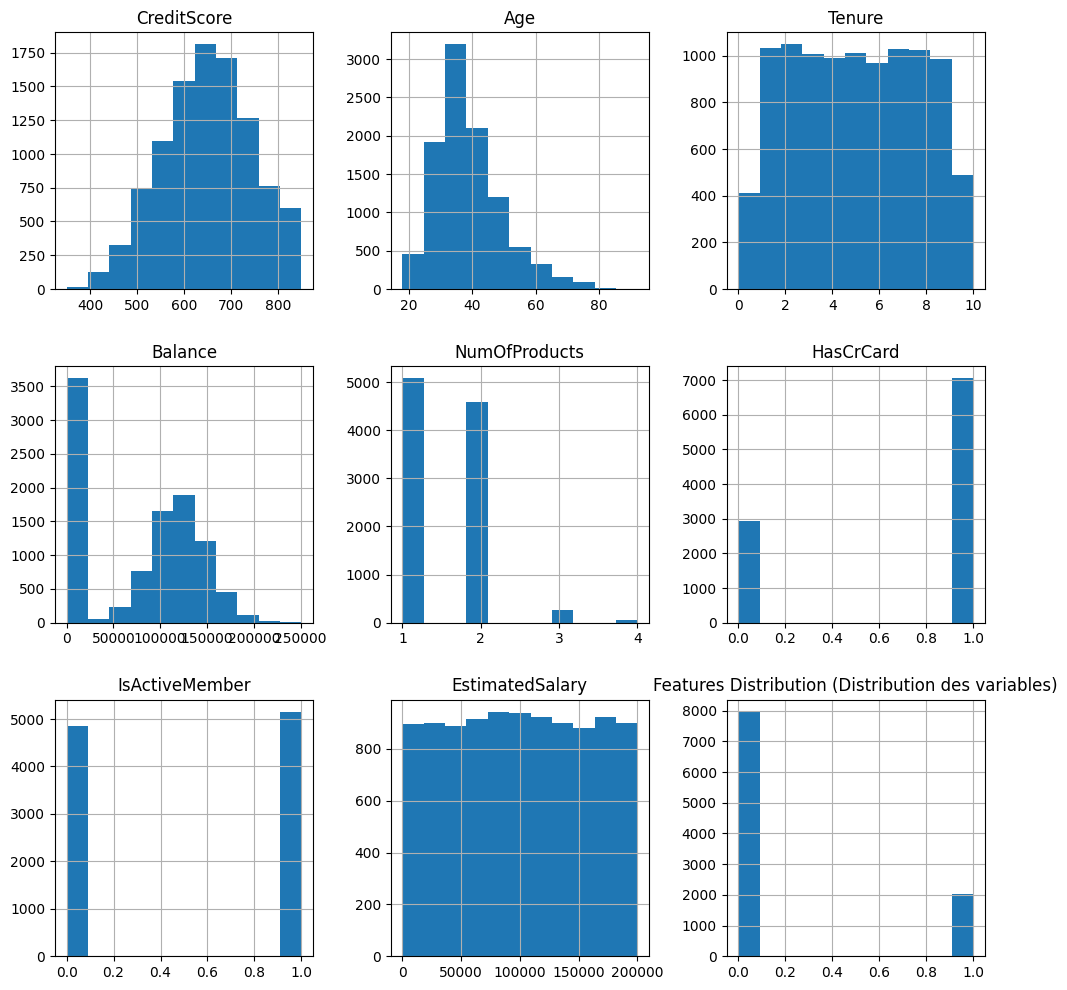

In [16]:
new_df.hist(figsize=(12, 12), bins = 11)
plt.title('Features Distribution (Distribution des variables)')
plt.show()

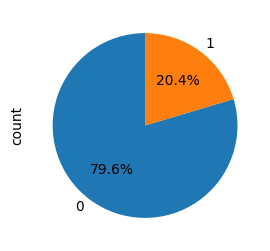

In [17]:
new_df['Exited'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, figsize=(3, 3))
plt.show()

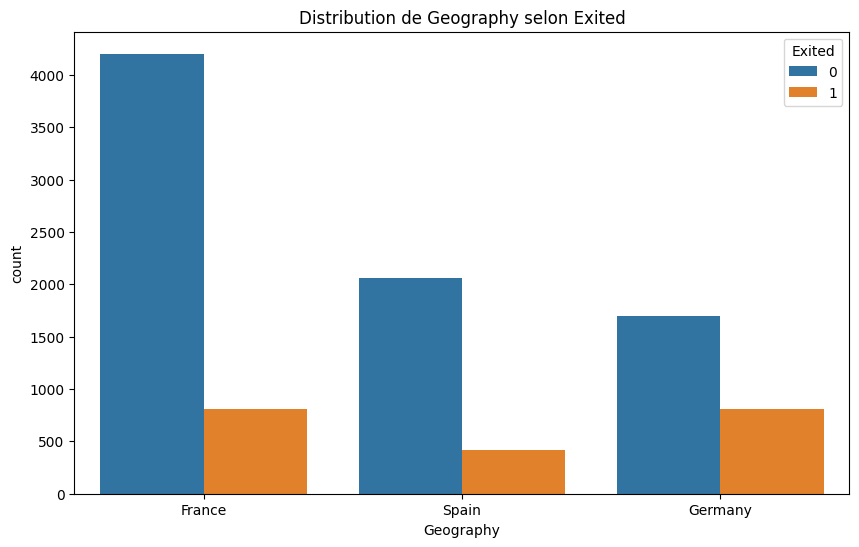

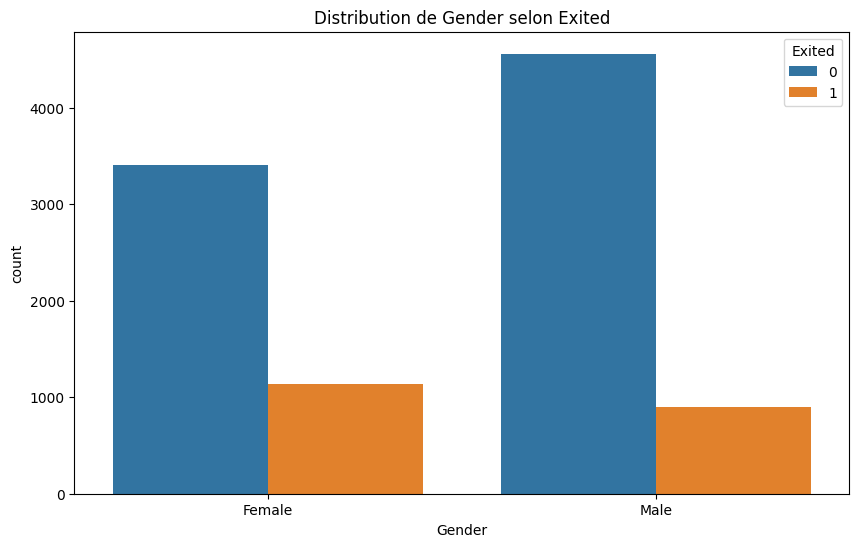

In [11]:
# Liste des variables catégorielles
categorical_columns = new_df.select_dtypes(include=['object']).columns

# Visualisation de la distribution des variables catégorielles
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='Exited', data=new_df)
    plt.title(f'Distribution de {col} selon Exited')
    plt.show()

# Construction et entraînement du réseau de neurones

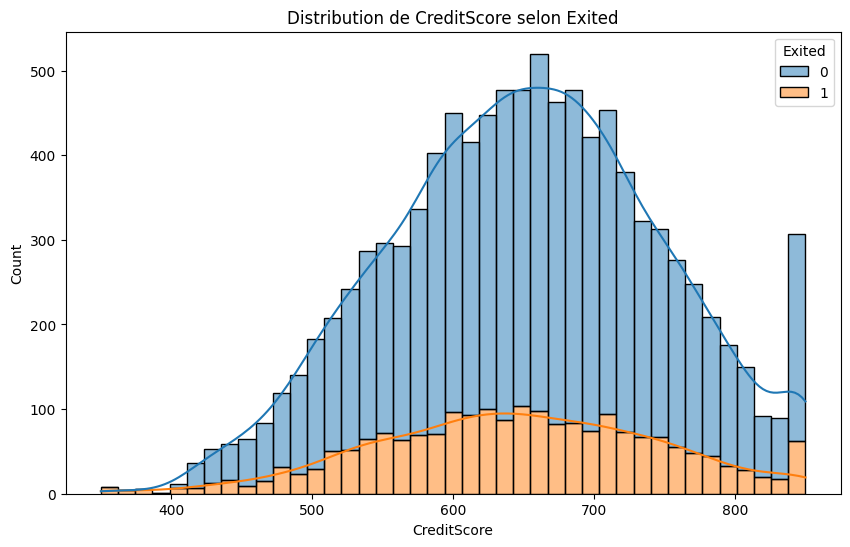

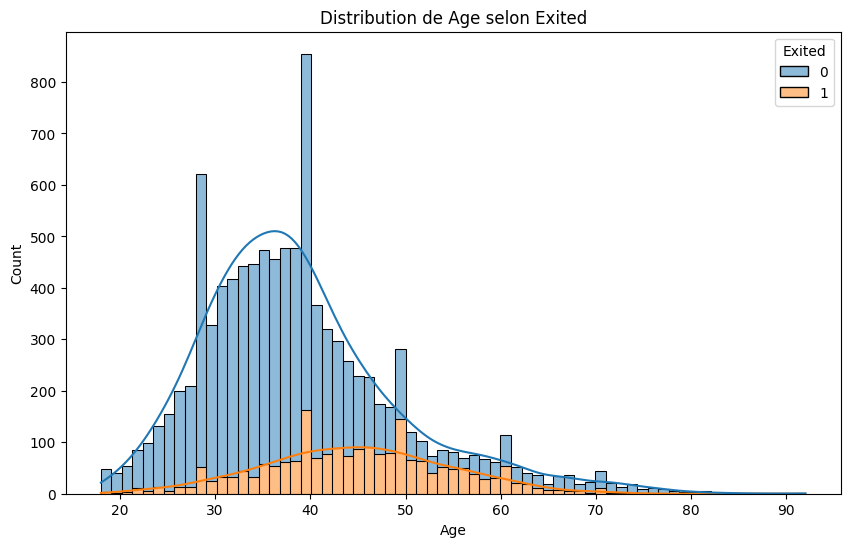

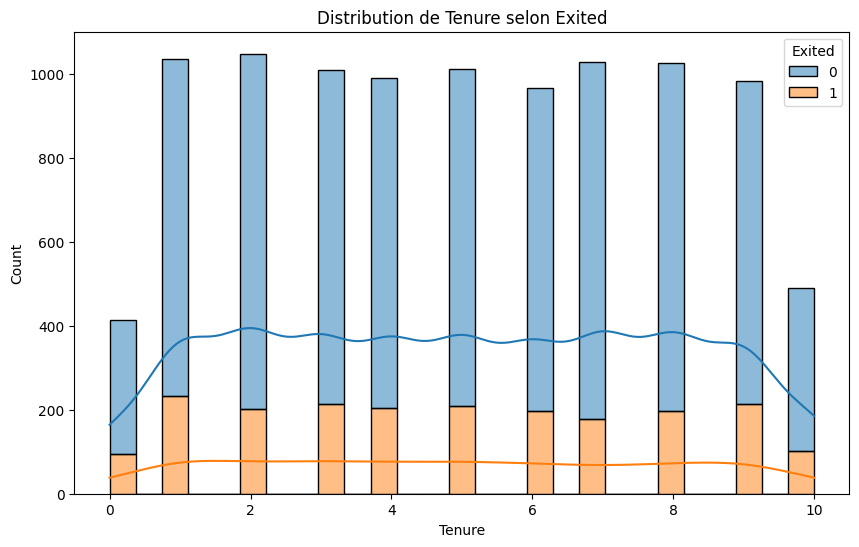

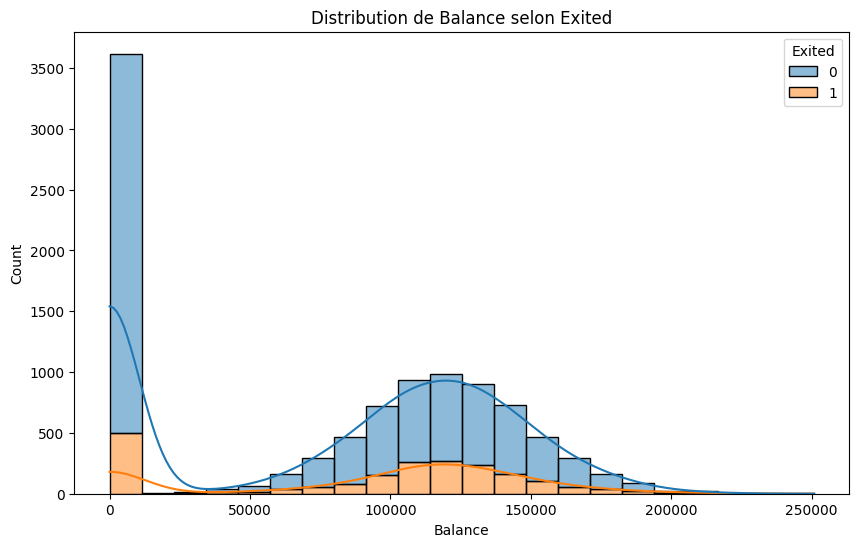

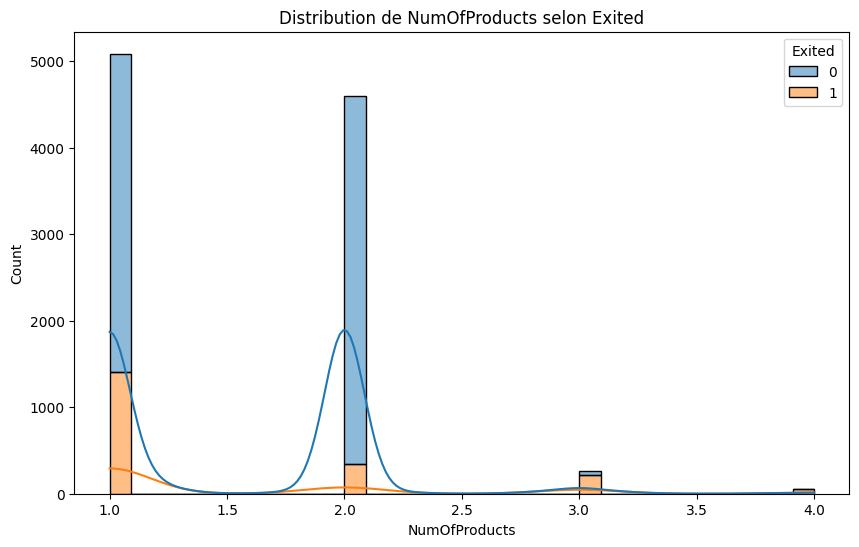

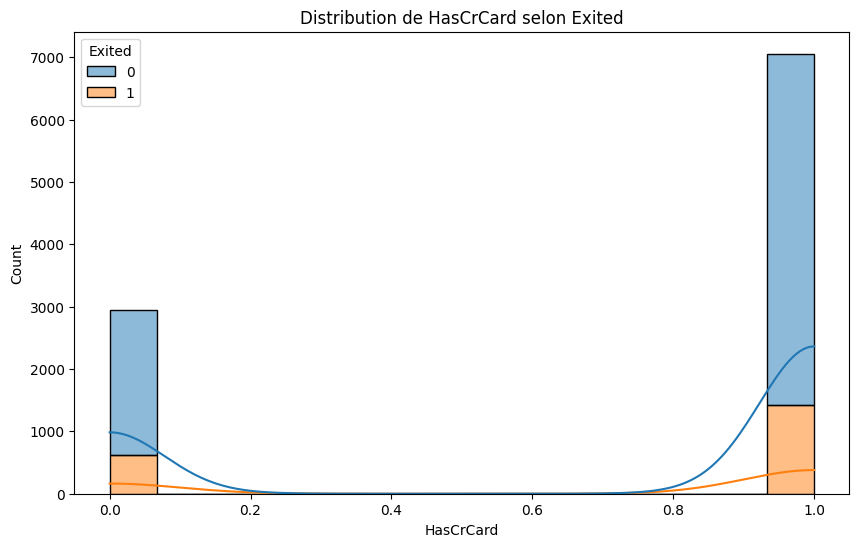

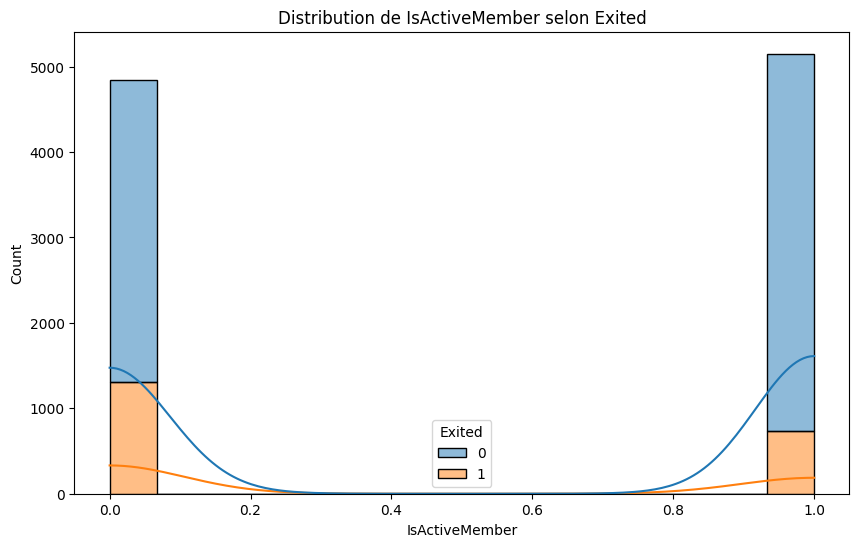

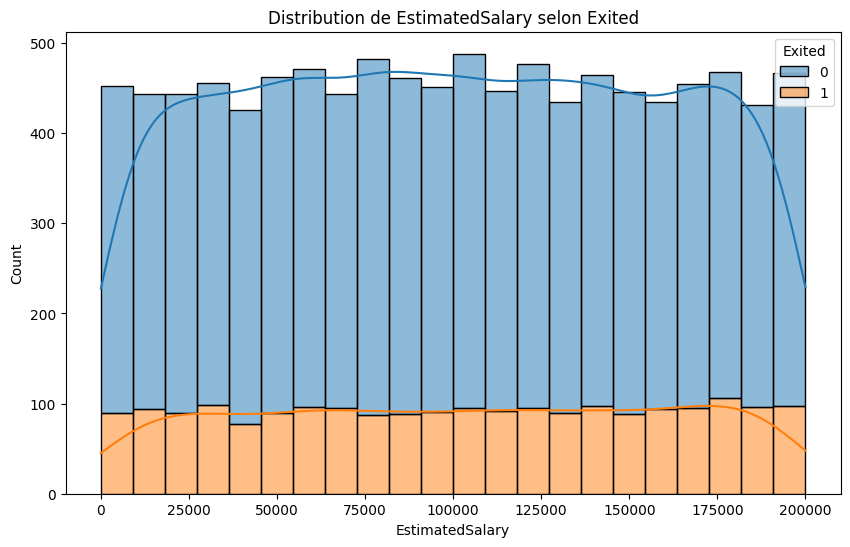

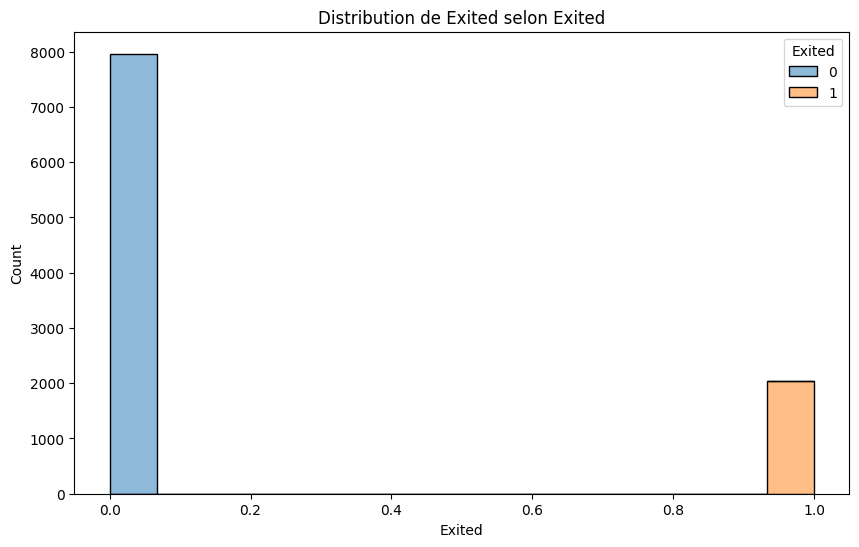

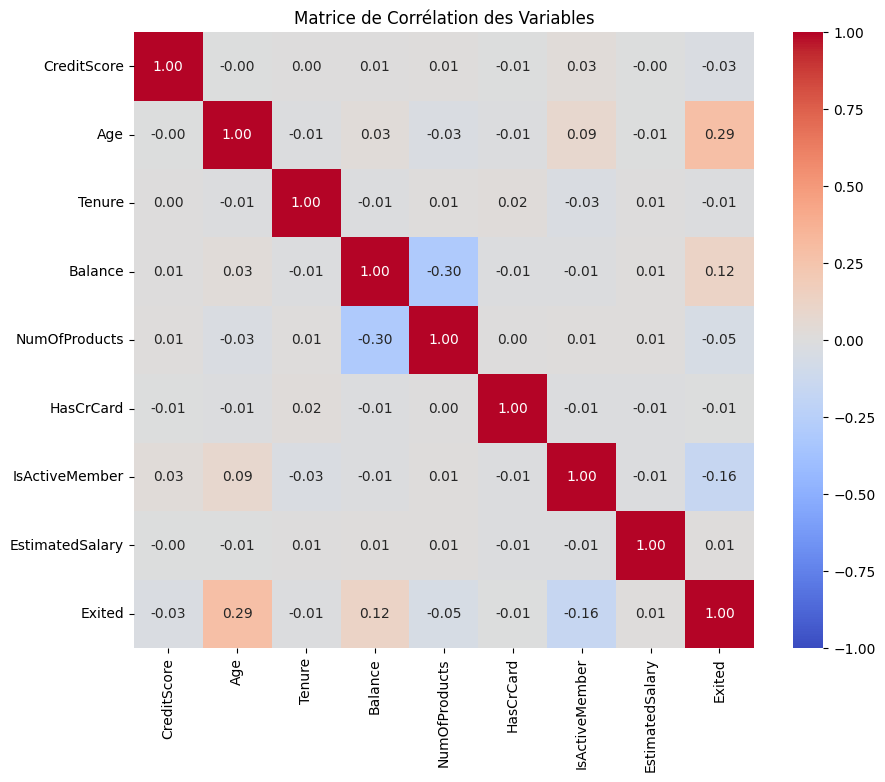

In [12]:
# Étudier les distributions des variables numériques selon Exited
numerical_columns = new_df.select_dtypes(include=['int64', 'float64']).columns

# Visualiser les distributions de chaque variable numérique selon Exited
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=col, hue='Exited', kde=True, multiple="stack")
    plt.title(f'Distribution de {col} selon Exited')
    plt.show()

# Étudier la corrélation entre les variables numériques
correlation_matrix = new_df[numerical_columns].corr()

# Afficher la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation des Variables')
plt.show()


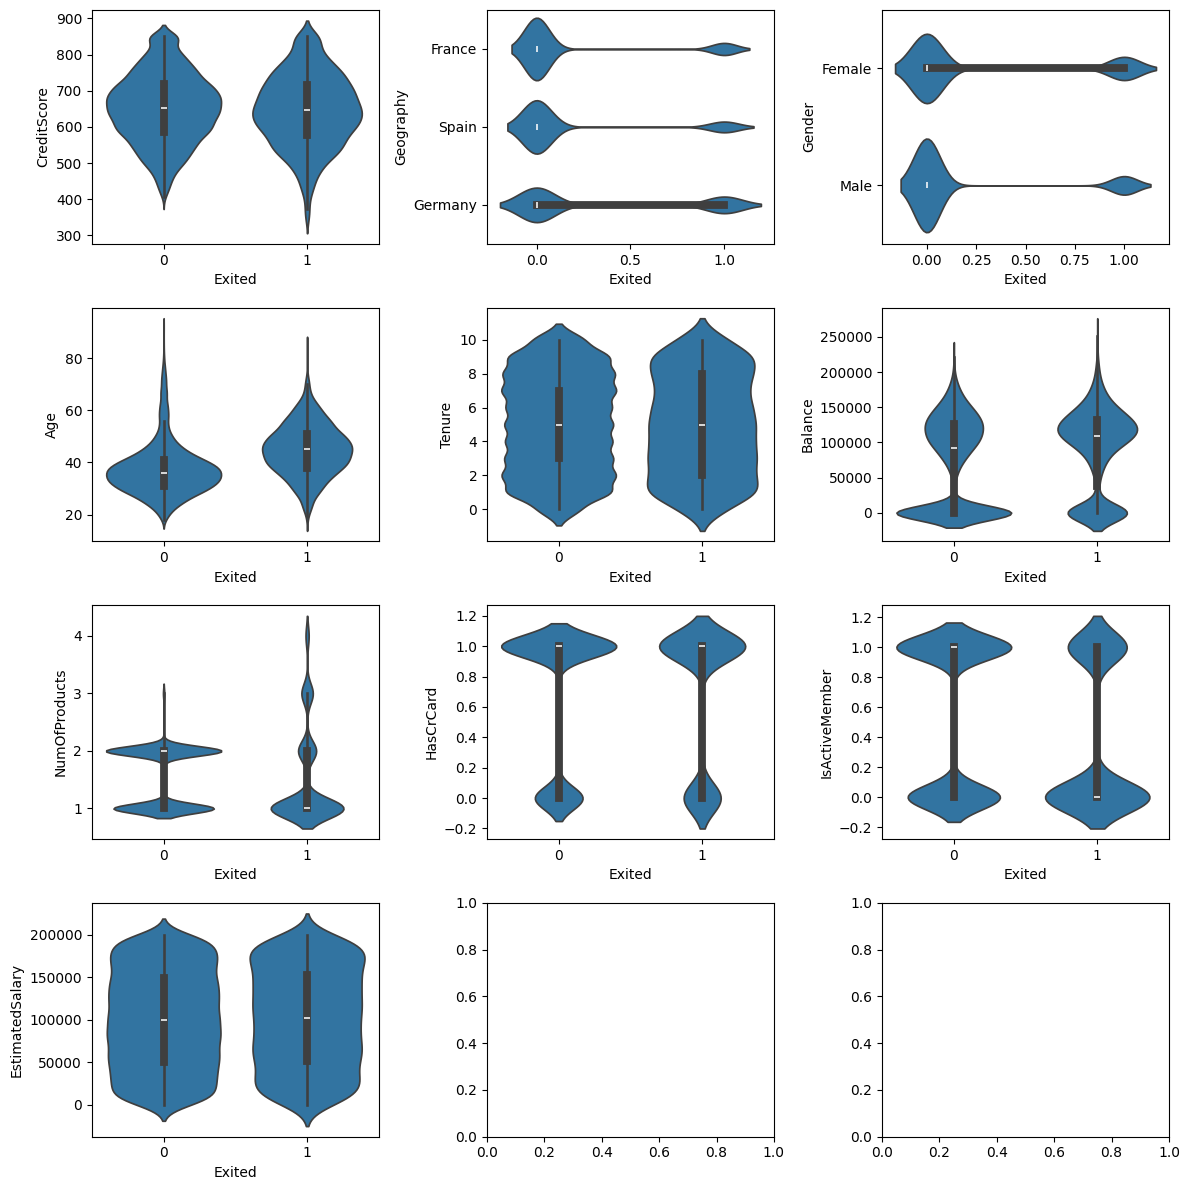

In [29]:
fig,ax = plt.subplots(nrows =4, ncols=3, figsize=(12, 12))
for i, col in enumerate(new_df.drop(columns="Exited").columns):
    axes = ax[i//3, i%3]
    sns.violinplot(x = new_df["Exited"], y= new_df[col], ax=axes)
plt.tight_layout()
plt.show()

**Séparer les données d'entraînement (`X_train`, `y_train`) et de test (`X_test`, `y_test`).**

*Veiller à convertir les données en arrays Numpy et la variable à prédire en une colonne (et non une ligne).**

In [30]:
# Variables indépendantes (tout sauf 'Exited')
X = new_df.drop(columns=['Exited'])

# Variable cible
y = new_df['Exited']


In [31]:
# Séparer les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir les données en arrays Numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Convertir la variable cible en une colonne Numpy
y_train = y_train.to_numpy().reshape(-1, 1)  # Convertir en colonne
y_test = y_test.to_numpy().reshape(-1, 1)  # Convertir en colonne

In [32]:
# Vérification des dimensions
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (8000, 10)
X_test shape: (2000, 10)
y_train shape: (8000, 1)
y_test shape: (2000, 1)


Nous allons ensuite normaliser les datasets et les convertir en *tensors*.

In [ ]:
import tensorflow as tf # Import TensorFlow

In [ ]:
# Create dummy variables for 'Geography' and 'Gender' before converting to numpy arrays
X = pd.get_dummies(new_df.drop(columns=['Exited']), columns=['Geography', 'Gender'], drop_first=True) # Create dummies directly from new_df

# Séparer les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir les données en arrays Numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Convertir la variable cible en une colonne Numpy
y_train = y_train.to_numpy().reshape(-1, 1)  # Convertir en colonne
y_test = y_test.to_numpy().reshape(-1, 1)  # Convertir en colonne

# Normalisation des données avec StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convertir les données normalisées en tensors TensorFlow
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32) # Use X_train instead of X_train_scaled
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32) # Use X_test instead of X_test_scaled

# Convertir les labels en tensors
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32) # No need for reshape, already a column
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32) # No need for reshape, already a column

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 11) (2000, 11) (8000, 1) (2000, 1)


**Construire un réseau de neurones séquentiel avec les propriétés suivantes :**
* Une première couche comportant six neurones et activée par ReLU,
* Une seconde couche comportant également six neurones et activée par ReLU,
* Une troisième et dernière couche, comportant le nombre de neurones la fonction d'activation appropriés.

In [53]:
input_shape = (11,)

model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(6, activation='relu'), # activation 'relu' est la plus utilisée pour la couche cachée
        keras.layers.Dense(6, activation='relu'), # activation 'relu' est la plus utilisée pour la couche cachée
        keras.layers.Dense(1, activation='sigmoid') # activiation 'sigmoid' pour la couche de sortie binaire (on vient définir que notre réseau va faire de la classification binaire)
    ]
)

**Combien de paramètres entraînables composent ce réseau ?**

In [85]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 6)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 6)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365 (1.43 KB)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244 (980.00 B)

In [55]:
layers = {
    "layer_1": (11 * 6 ) + 6,
    "layer_2": (6 * 6) + 6,
    "layer_3": (6 * 1) + 1
}
for layer_name, layer_size in layers.items():
    print(f"{layer_name}: {layer_size} neurones")

    network_size = sum(layers.values())
    print(f"Au total, il y a {network_size} neurones dans le réseau.")

layer_1: 72 neurones
Au total, il y a 121 neurones dans le réseau.
layer_2: 42 neurones
Au total, il y a 121 neurones dans le réseau.
layer_3: 7 neurones
Au total, il y a 121 neurones dans le réseau.


**Définir la fonction de perte (*loss function*) et l'optimiseur du modèle avec un learning-rate égal à `1e-2`.**

In [94]:
from tensorflow.keras.optimizers import Adam

# étape de compilation
model.compile(
    optimizer=Adam(learning_rate=1e-2),
    loss='binary_crossentropy', #categorical_crossentropy, sparse_categorical_crossentropy
    metrics=['accuracy']
    )

Nous pouvons maintenant passer à la phase d'entraînement :

In [95]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8005 - loss: 0.4999 - val_accuracy: 0.8035 - val_loss: 0.4958
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7908 - loss: 0.5130 - val_accuracy: 0.8035 - val_loss: 0.4956
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7932 - loss: 0.5097 - val_accuracy: 0.8035 - val_loss: 0.4958
Epoch 4/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7988 - loss: 0.5023 - val_accuracy: 0.8035 - val_loss: 0.4959
Epoch 5/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7956 - loss: 0.5065 - val_accuracy: 0.8035 - val_loss: 0.4959
Epoch 6/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7922 - loss: 0.5110 - val_accuracy: 0.8035 - val_loss: 0.4957
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7884 - loss: 0.5163 - val_accuracy: 0.8035 - val_loss: 0.4956
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7940 - loss: 0.5089 - val_accuracy: 0.

**Afficher l'évolution de l'erreur sur les datasets d'entraînement et de test.**

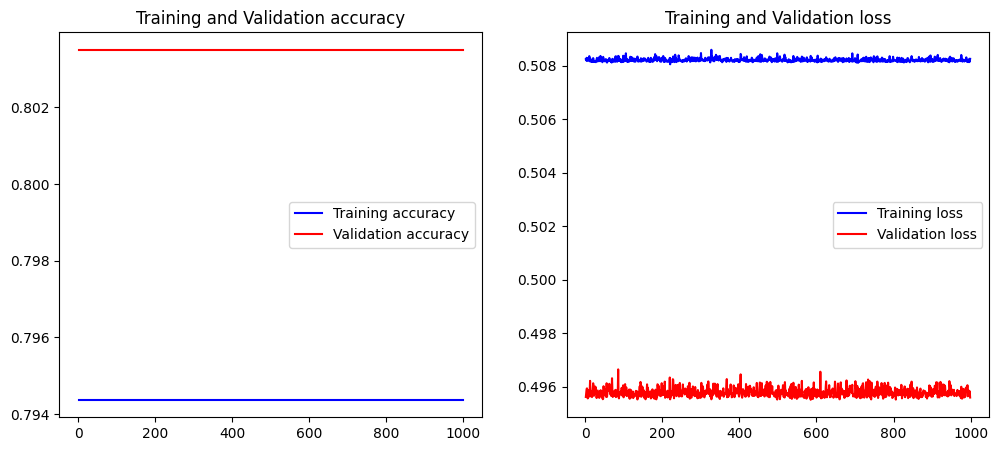

In [96]:
def plot_history(history):
  """Plots accuracy and loss for training and validation data."""
  accuracy = history.history['accuracy'][1:]
  val_accuracy = history.history['val_accuracy'][1:]
  loss = history.history['loss'][1:]
  val_loss = history.history['val_loss'][1:]
  x = range(1, len(accuracy) + 1)

  # Plot training & validation accuracy values
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(x, accuracy, 'b', label='Training accuracy')
  plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()

# Call the function with your history object
plot_history(history)

In [99]:
# étape de compilation
model.compile(
    optimizer=Adam(learning_rate=1e-2),
    loss='binary_crossentropy', #categorical_crossentropy, sparse_categorical_crossentropy
    metrics=['accuracy']
    )

In [100]:
history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7953 - loss: 0.5069 - val_accuracy: 0.8035 - val_loss: 0.4959
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7908 - loss: 0.5130 - val_accuracy: 0.8035 - val_loss: 0.4956
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8005 - loss: 0.4998 - val_accuracy: 0.8035 - val_loss: 0.4959
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7939 - loss: 0.5088 - val_accuracy: 0.8035 - val_loss: 0.4959
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7957 - loss: 0.5064 - val_accuracy: 0.8035 - val_loss: 0.4957
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7954 - loss: 0.5068 - val_accuracy: 0.8035 - val_loss: 0.4959
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7886 - loss: 0.5159 - val_accuracy: 0.8035 - val_loss: 0.4957
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8001 - loss: 0.5004 - val_accuracy: 0.8035 - v

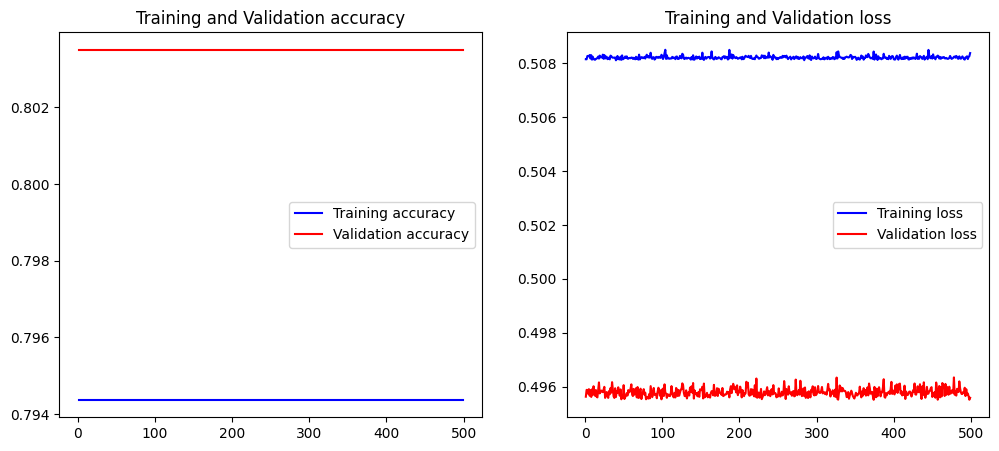

In [101]:
def plot_history(history):
  """Plots accuracy and loss for training and validation data."""
  accuracy = history.history['accuracy'][1:]
  val_accuracy = history.history['val_accuracy'][1:]
  loss = history.history['loss'][1:]
  val_loss = history.history['val_loss'][1:]
  x = range(1, len(accuracy) + 1)

  # Plot training & validation accuracy values
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(x, accuracy, 'b', label='Training accuracy')
  plt.plot(x, val_accuracy, 'r', label='Validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()

# Call the function with your history object
plot_history(history)

# Evaluation du modèle

**Afficher les prédictions sur le dataset de test. A quoi correspondent ces valeurs ? Les convertir pour qu'elles correspondent à la classe prédite.**

In [102]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Training accuracy: {accuracy}")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Testing accuracy: {accuracy}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7933 - loss: 0.5097
Training accuracy: 0.7943750023841858
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.4969
Testing accuracy: 0.8034999966621399


In [70]:
y_test_pred = model.predict(X_test)
y_test_pred[:10]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0.06576022],
       [0.00963292],
       [0.16154225],
       [0.06920987],
       [0.06402496],
       [0.01545677],
       [0.07082009],
       [0.17338456],
       [0.28829494],
       [0.46486717]], dtype=float32)

**Evaluer le modèle avec les métriques habituelles.**

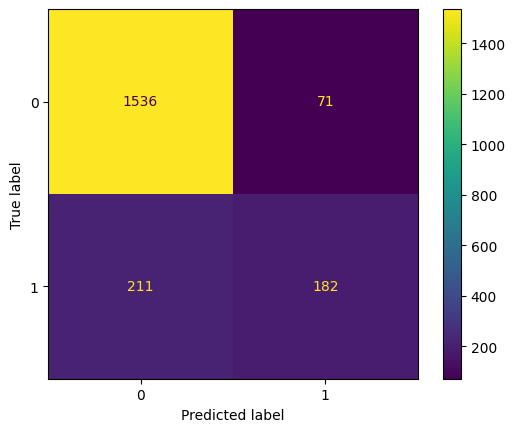

In [77]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred>0.5)
plt.show()

In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred>0.5))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.72      0.46      0.56       393

    accuracy                           0.86      2000
   macro avg       0.80      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000



In [79]:
print(f"F1_score: {f1_score(y_test, y_test_pred>0.5)}")

F1_score: 0.5634674922600619


# Influence du learning rate

**Entraîner la même architecture de réseau de neurones avec les learning rates suivants : `1e-3` et `1`. Quelles conclusions en tirez-vous sur l'importance du learning rate ?**

## Avec lr=0.001

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5999 - loss: 0.6495 - val_accuracy: 0.7420 - val_loss: 0.5501
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7431 - loss: 0.5447 - val_accuracy: 0.8025 - val_loss: 0.4864
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7960 - loss: 0.4882 - val_accuracy: 0.8035 - val_loss: 0.4565
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7890 - loss: 0.4691 - val_accuracy: 0.8035 - val_loss: 0.4420
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7955 - loss: 0.4574 - val_accuracy: 0.8035 - val_loss: 0.4323
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7936 - loss: 0.4461 - val_accuracy: 0.8040 - val_loss: 0.4242
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7963 - loss: 0.4294 - val_accuracy: 0.8055 - val_loss: 0.4176
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7997 - loss: 0.4214 - val_accuracy: 0.806

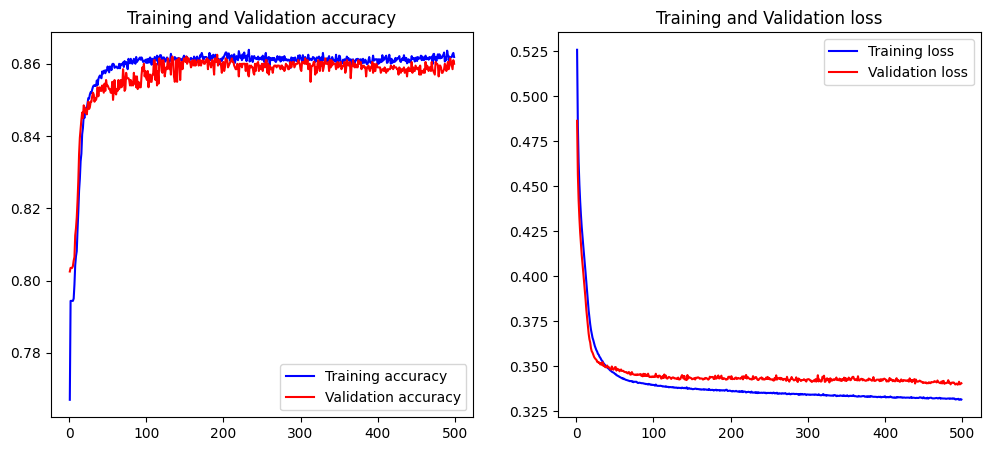

In [80]:
input_shape = (11,)

model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(6, activation='relu'), # activation 'relu' est la plus utilisée pour la couche cachée
        keras.layers.Dense(6, activation='relu'), # activation 'relu' est la plus utilisée pour la couche cachée
        keras.layers.Dense(1, activation='sigmoid') # activiation 'sigmoid' pour la couche de sortie binaire (on vient définir que notre réseau va faire de la classification binaire)
    ]
)

# étape de compilation
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy', #categorical_crossentropy, sparse_categorical_crossentropy
    metrics=['accuracy']
    )

history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test))

plot_history(history)

## Avec lr=1

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7592 - loss: 0.8751 - val_accuracy: 0.8035 - val_loss: 0.5014
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7901 - loss: 0.5189 - val_accuracy: 0.8035 - val_loss: 0.4960
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7922 - loss: 0.5143 - val_accuracy: 0.8035 - val_loss: 0.4989
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7889 - loss: 0.5186 - val_accuracy: 0.8035 - val_loss: 0.4955
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7936 - loss: 0.5124 - val_accuracy: 0.8035 - val_loss: 0.4970
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7899 - loss: 0.5251 - val_accuracy: 0.8035 - val_loss: 0.4959
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7933 - loss: 0.5265 - val_accuracy: 0.8035 - val_loss: 0.4979
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7982 - loss: 0.5066 - val_accuracy: 0.8035 - v

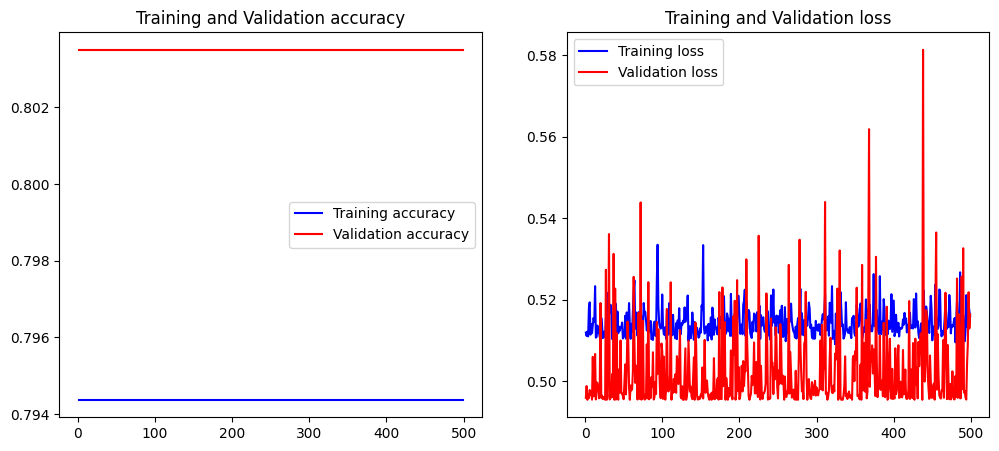

In [81]:
input_shape = (11,)

model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(6, activation='relu'), # activation 'relu' est la plus utilisée pour la couche cachée
        keras.layers.Dense(6, activation='relu'), # activation 'relu' est la plus utilisée pour la couche cachée
        keras.layers.Dense(1, activation='sigmoid') # activiation 'sigmoid' pour la couche de sortie binaire (on vient définir que notre réseau va faire de la classification binaire)
    ]
)

# étape de compilation
model.compile(
    optimizer=Adam(learning_rate=1.),
    loss='binary_crossentropy', #categorical_crossentropy, sparse_categorical_crossentropy
    metrics=['accuracy']
    )

history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test))

plot_history(history)

# Comparaison avec d'autres modèles

**Comparer les performances du réseau de neurones avec une régression logistique classique.**

<ipython-input-83-f56f2df190ae>:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  log_reg.fit(X_train, y_train.ravel())


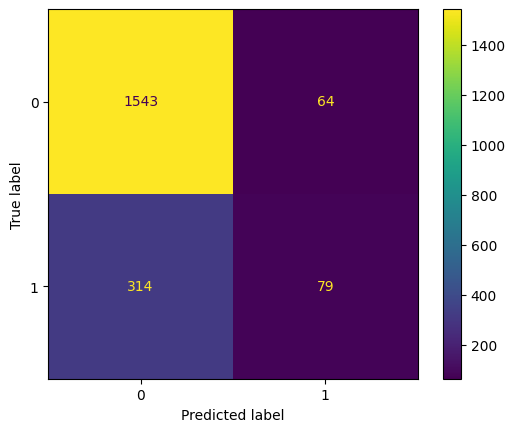

In [83]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train.ravel())
y_pred = log_reg.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [84]:
print(f"F1-score: {f1_score(y_test, y_pred)}")

F1-score: 0.2947761194029851
